In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from sklearn.cluster import KMeans
import numpy.matlib
import statsmodels.formula.api as smf

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pathlength_tuning/1_code/')
from func import set_proj_env, my_get_cmap, rank_int, get_fdr_p, get_pdist, get_adj_stats, my_regplot, my_nullplot

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 400 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
set_proj_env()

('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/0_data',
 '/Volumes/work_ssd/research_data/PNC/',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output')

In [5]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_400_streamlineCount_'

### Setup directory variables

In [6]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output/figs


### Parameters

In [8]:
control_list = ['minimum','minimum_taylor']; control = control_list[0]
T_list = [1,]; T = T_list[0]
B_list = ['x0xfwb',]; B_ver = B_list[0]

num_parcels=parc_scale
n_clusters=int(num_parcels*.05)
print(n_clusters)
n_subsamples = 20

20


In [9]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear','F1_Exec_Comp_Res_Accuracy','F3_Executive_Efficiency','Overall_Speed']
# phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
# phenos_label = ['Overall psychopathology','Psychosis (positive)','Psychosis (negative)','Anxious-misery','Externalizing','Fear']
# phenos_label_short = ['Ov. psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
pheno = phenos[0]
print(pheno)

Overall_Psychopathology


### Setup plots

In [10]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'talk', font_scale = 1)
cmap = my_get_cmap('pair')

# Load group A matrix data

### Cortical gradients

[58 17 14 16 17 10 17 37 19 32 19 29 11 30  7  7 10 23  7 20]


Text(0, 0.5, 'Gradient 1')

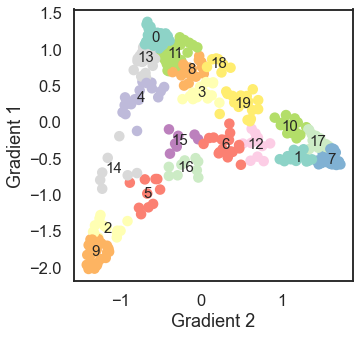

In [11]:
gradients = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '1_compute_gradient', 'out', outfile_prefix+'pnc_grads_template.txt'))
num_parcels = gradients.shape[0]

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(gradients)

unique, counts = np.unique(kmeans.labels_, return_counts = True)
print(counts)

f, ax = plt.subplots(figsize=(5, 5))
ax.scatter(gradients[:,1], gradients[:,0], c = kmeans.labels_, cmap= 'Set3')
# ax.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], marker = 'x', c = 'k', s = 100)
for i, txt in enumerate(np.arange(n_clusters)):
    ax.annotate(txt, (kmeans.cluster_centers_[i,1], kmeans.cluster_centers_[i,0]), ha="center", va="center", size=15)
ax.set_xlabel('Gradient 2')
ax.set_ylabel('Gradient 1')

### MNI Centroids

In [12]:
centroids = pd.read_csv(os.path.join(os.environ['PROJDIR'],'figs_support','labels','schaefer'+str(parc_scale),'Schaefer2018_'+str(parc_scale)+'Parcels_17Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'))
centroids.drop('ROI Name', axis = 1, inplace = True)
centroids.set_index('ROI Label', inplace=True)
centroids.head()

,R,A,S
ROI Label,,,
1,-36,-62,-17
2,-23,-73,-10
3,-36,-81,-16
4,-17,-86,-15
5,-24,-97,-12


### Group A matrix (6% sparsity)

In [13]:
A = np.load(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out', outfile_prefix+'disc_mean_A_s6.npy'))
D_mean, hops_mean, tm_con, tm_var, smv_con, smv_var, joint_var, num_tm_flips, num_smv_flips = get_adj_stats(A, gradients, kmeans.labels_, return_abs = False)

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/bct/algorithms/distance.py:392: RuntimeWarning: divide by zero encountered in true_divide
  SPL = 1. / adjacency


### Compute distances

In [14]:
dist_mni = get_pdist(centroids.values,kmeans.labels_, method = 'median')
dist_mni[np.eye(dist_mni.shape[0]) == 1] = np.nan

dist_h = sp.spatial.distance.squareform(sp.spatial.distance.pdist(kmeans.cluster_centers_))
dist_h[np.eye(dist_h.shape[0]) == 1] = np.nan

# Load participant data

In [15]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out', outfile_prefix+'df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)

df = df.loc[df['disc_repl'] == 0,:]
print(df.shape)

(460, 59)


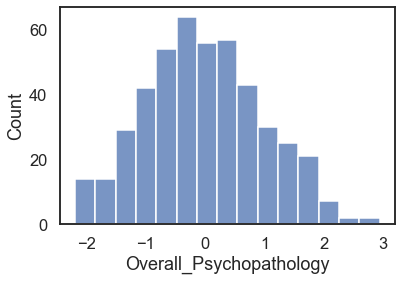

In [16]:
sns.histplot(df[pheno])

## Energy

In [17]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [18]:
E = np.zeros((n_clusters, n_clusters, n_subsamples, df.shape[0]))

for i in tqdm(np.arange(df.shape[0])):
    subjid = str(df.iloc[i].name[0])+'_'+str(df.iloc[i].name[1])
    file_label = subjid+'_'+control+'_T-'+str(T)+'_B-'+B_ver+'-g'+str(n_clusters)
    if i == 0: print(file_label)
    
    try:
        E[:,:,:,i] = np.load(os.path.join(os.environ['PIPELINEDIR'], '2_compute_energy', 'out', outfile_prefix[:-1],
                                          file_label+'_E.npy'))
    except:
        print(subjid + ': NOT FOUND')
        subj_filt[i] = True

 29%|██▉       | 135/460 [00:00<00:00, 680.05it/s]

81287_2738_minimum_T-1_B-x0xfwb-g20
92860_3371: NOT FOUND


100%|██████████| 460/460 [00:00<00:00, 707.55it/s]


In [19]:
np.sum(subj_filt)

1

In [20]:
if any(subj_filt):
    E = E[:,:,:,~subj_filt]
    df = df.loc[~subj_filt]

In [21]:
# mean over subsamples
E = np.mean(E, axis = 2)
E.shape

(20, 20, 459)

In [22]:
# # normalize
# for i in np.arange(n_clusters):
#     for j in np.arange(n_clusters):
#         if i != j:
#             E[i,j,:] = rank_int(pd.Series(data=E[i,j,:])).values

## Individuals' adj stats

In [23]:
hops_inds = np.zeros((num_parcels, num_parcels, df.shape[0]))
tm_var_inds = np.zeros((num_parcels, num_parcels, df.shape[0]))
smv_var_inds = np.zeros((num_parcels, num_parcels, df.shape[0]))

for i in tqdm(np.arange(df.shape[0])):
    subjid = str(df.iloc[i].name[0])+'_'+str(df.iloc[i].name[1])
    adj_stats = np.load(os.path.join(os.environ['PIPELINEDIR'], '3_compute_adj_stats', 'out', outfile_prefix[:-1], subjid+'_adj_stats.npy'), allow_pickle = True)
    adj_stats = adj_stats.item()
    
    hops_inds[:,:,i] = adj_stats['hops']
    tm_var_inds[:,:,i] = adj_stats['tm_var']
    smv_var_inds[:,:,i] = adj_stats['smv_var']

100%|██████████| 459/459 [00:08<00:00, 54.57it/s]


# Nuisance regression

In [24]:
df['sex_adj'] = df['sex'] - 1
covs = ['sex_adj', 'ageAtScan1_Years', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']
covs = []
# covs = ['sex_adj', 'ageAtScan1_Years']
# covs = ['ageAtScan1_Years']

In [25]:
if len(covs) > 0:
    print('running nuisance regression...')
    df_nuis = df.loc[:,covs]
    df_nuis = sm.add_constant(df_nuis)

    mdl = sm.OLS(df.loc[:,phenos], df_nuis).fit()
    y_pred = mdl.predict(df_nuis)
    y_pred.columns = phenos
    df.loc[:,phenos] = df.loc[:,phenos] - y_pred

    for i in np.arange(n_clusters):
        for j in np.arange(n_clusters):
            mdl = sm.OLS(E[i,j,:], df_nuis).fit()
            y_pred = mdl.predict(df_nuis)
            y_resid = E[i,j,:] - y_pred
            E[i,j,:] = y_resid

# Results

## Plot correlations between pheno and energy

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


183


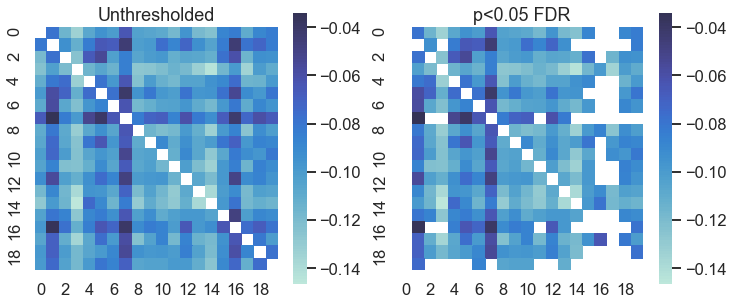

In [26]:
r = np.zeros((n_clusters, n_clusters))
pval = np.zeros((n_clusters, n_clusters))

for i in np.arange(n_clusters):
    for j in np.arange(n_clusters):
        r[i,j], pval[i,j] = sp.stats.pearsonr(df.loc[:,pheno],E[i,j,:])
#         r[i,j], pval[i,j] = sp.stats.spearmanr(df.loc[:,pheno],E[i,j,:])

if T == 1:
    pval = get_fdr_p(pval)
print(np.sum(pval<.05))

f, ax = plt.subplots(1,2, figsize=(12, 5))
mask = np.eye(r.shape[0]).astype(bool)
sns.heatmap(r, square = True, center = 0, vmax = r[~mask].max(), vmin = r[~mask].min(), ax = ax[0])
ax[0].set_title('Unthresholded')
if np.sum(pval<.05) != 0:
    mask = np.logical_or(pval >= 0.05, np.eye(r.shape[0]))
    sns.heatmap(r, square = True, center = 0, vmax = r[~mask].max(), vmin = r[~mask].min(), ax = ax[1], mask = mask)
    ax[1].set_title('p<0.05 FDR')

f.savefig(outfile_prefix+'correlations.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)

#### Get indices of elements

In [27]:
# indices = np.triu_indices(n_clusters, k=1)
# indices = np.tril_indices(n_clusters, k=-1)
indices = np.where(~np.eye(n_clusters,dtype=bool))
len(indices[0])

380

## Plot hops against variances

100%|██████████| 459/459 [00:00<00:00, 1960.03it/s]


Text(0.5, 1.0, 'corr(hops, unimodal)')

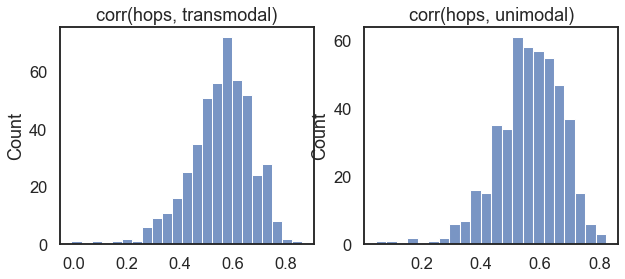

In [28]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

r_hops_var = np.zeros(df.shape[0])
for i in tqdm(np.arange(df.shape[0])): r_hops_var[i] = sp.stats.spearmanr(hops_inds[:,:,i][indices], tm_var_inds[:,:,i][indices])[0]
sns.histplot(r_hops_var, ax=ax[0])
ax[0].set_title('corr(hops, transmodal)')

r_hops_var = np.zeros(df.shape[0])
for i in tqdm(np.arange(df.shape[0])): r_hops_var[i] = sp.stats.spearmanr(hops_inds[:,:,i][indices], smv_var_inds[:,:,i][indices])[0]
sns.histplot(r_hops_var, ax=ax[1])
ax[1].set_title('corr(hops, unimodal)')

## Plot null models

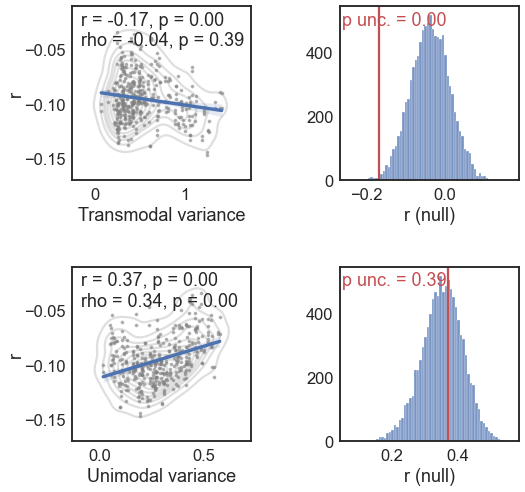

In [29]:
num_surrogates = 10000
surr_type = 'spatial_wssp' # 'standard' 'spatial_wwp' 'spatial_wsp' 'spatial_wssp'
# surr_type = surr_type+'_hybrid'
surr_type = surr_type+'_grad_cmni'
# surr_type = surr_type+'_mni_cgrad'

tm_var_surr = np.load(os.path.join(os.environ['PIPELINEDIR'], '4_compute_adj_stats_surrogates', 'out', outfile_prefix[:-1], 'disc_mean_A_s6_'+surr_type+'_grad'+str(n_clusters)+'_tm_var_surr.npy'))
smv_var_surr = np.load(os.path.join(os.environ['PIPELINEDIR'], '4_compute_adj_stats_surrogates', 'out', outfile_prefix[:-1], 'disc_mean_A_s6_'+surr_type+'_grad'+str(n_clusters)+'_smv_var_surr.npy'))
joint_var_surr = np.load(os.path.join(os.environ['PIPELINEDIR'], '4_compute_adj_stats_surrogates', 'out', outfile_prefix[:-1], 'disc_mean_A_s6_'+surr_type+'_grad'+str(n_clusters)+'_joint_var_surr.npy'))

if tm_var_surr.shape[2] > num_surrogates:
    tm_var_surr = tm_var_surr[:,:,:num_surrogates]
    smv_var_surr = smv_var_surr[:,:,:num_surrogates]
    joint_var_surr = joint_var_surr[:,:,:num_surrogates]

f, ax = plt.subplots(2, 2, figsize=(8, 8))

my_regplot(tm_var[indices], r[indices], 'Transmodal variance', 'r', ax[0,0])
my_nullplot(tm_var[indices], tm_var_surr[indices], r[indices], 'r (null)', ax=ax[0,1])

my_regplot(smv_var[indices], r[indices], 'Unimodal variance', 'r', ax[1,0])
my_nullplot(smv_var[indices], smv_var_surr[indices], r[indices], 'r (null)', ax=ax[1,1])

f.subplots_adjust(wspace=0.5, hspace=0.5)
f.savefig(outfile_prefix+'correlations_vs_adjstats_null.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)    

# Taylor series models

In [30]:
control = control_list[1]; print(control)

minimum_taylor


In [31]:
n_taylor = 7

In [32]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [33]:
E_taylor = np.zeros((n_clusters, n_clusters, n_subsamples, n_taylor, df.shape[0]))

for i in np.arange(df.shape[0]):
    subjid = str(df.iloc[i].name[0])+'_'+str(df.iloc[i].name[1])
    file_label = subjid+'_'+control+'_T-'+str(T)+'_B-'+B_ver+'-g'+str(n_clusters)
    if i == 0: print(file_label)
    
    try:
        E_taylor[:,:,:,:,i] = np.load(os.path.join(os.environ['PIPELINEDIR'], '2_compute_energy', 'out', outfile_prefix[:-1],
                                      file_label+'_E.npy'))[:,:,:,:n_taylor]
    except:
        print(subjid + ': NOT FOUND')
        subj_filt[i] = True

81287_2738_minimum_taylor_T-1_B-x0xfwb-g20
88013_3216: NOT FOUND
85983_3345: NOT FOUND
90262_3646: NOT FOUND
95116_3998: NOT FOUND
93116_4031: NOT FOUND
91560_4075: NOT FOUND
98488_4212: NOT FOUND
99844_4223: NOT FOUND
112061_4614: NOT FOUND
105176_5077: NOT FOUND
114712_5197: NOT FOUND
122325_5320: NOT FOUND
126852_5592: NOT FOUND
121035_5631: NOT FOUND
126203_5677: NOT FOUND
91074_6219: NOT FOUND
127806_6329: NOT FOUND
125506_6370: NOT FOUND
127008_6680: NOT FOUND
120818_6757: NOT FOUND
122091_7283: NOT FOUND
108972_8283: NOT FOUND


In [34]:
np.sum(subj_filt)

22

In [35]:
if any(subj_filt):
    E_taylor = E_taylor[:,:,:,:,~subj_filt]
    df = df.loc[~subj_filt]

In [36]:
# mean over subsamples
E_taylor = np.mean(E_taylor, axis = 2)
E_taylor.shape

(20, 20, 7, 437)

### Recompute correlations

In [37]:
r_taylor = np.zeros((n_clusters, n_clusters, n_taylor))

for i in np.arange(n_clusters):
    for j in np.arange(n_clusters):
        for t in np.arange(n_taylor):
            r_taylor[i,j,t] = sp.stats.pearsonr(df.loc[:,pheno],E_taylor[i,j,t,:])[0]

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [38]:
r_max_corr = np.zeros((n_clusters, n_clusters))
r_max_corr_taylor = np.zeros((n_clusters, n_clusters))
r_min_corr = np.zeros((n_clusters, n_clusters))
r_min_corr_taylor = np.zeros((n_clusters, n_clusters))

for i in np.arange(n_clusters):
    for j in np.arange(n_clusters):
        r_max_corr[i,j] = np.max(np.abs(r_taylor[i,j,:]))
        r_max_corr_taylor[i,j] = np.argmax(np.abs(r_taylor[i,j,:]))
        r_min_corr[i,j] = np.min(np.abs(r_taylor[i,j,:]))
        r_min_corr_taylor[i,j] = np.argmin(np.abs(r_taylor[i,j,:]))
        
r_max_corr_taylor[np.eye(n_clusters).astype(bool)] = np.nan
r_min_corr_taylor[np.eye(n_clusters).astype(bool)] = np.nan

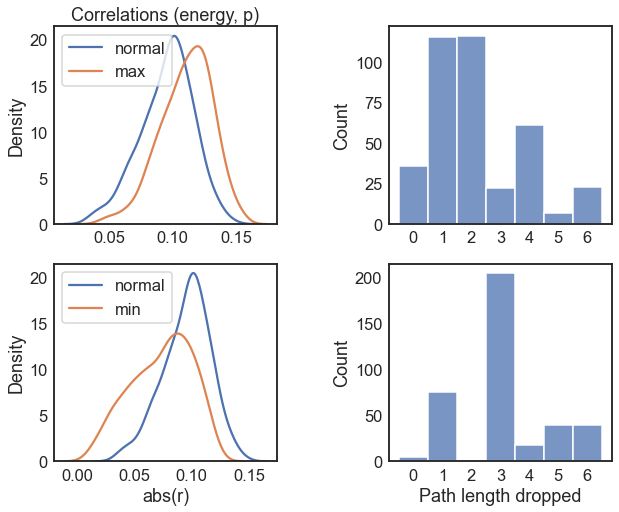

In [39]:
f, ax = plt.subplots(2, 2, figsize=(10, 8))

sns.kdeplot(np.abs(r[indices]), ax=ax[0,0], label = 'normal')
sns.kdeplot(r_max_corr[indices], ax=ax[0,0], label = 'max')
ax[0,0].legend()
ax[0,0].tick_params(pad = -2.5)
# ax[0,0].set_xlabel('abs(r)')
ax[0,0].set_title('Correlations (energy, p)')
sns.histplot(r_max_corr_taylor[indices], ax=ax[0,1], discrete = True)
# ax[0,1].set_xlabel('Path length dropped')
ax[0,1].set_xticks(np.arange(0,n_taylor))
ax[0,1].tick_params(pad = -2.5)

sns.kdeplot(np.abs(r[indices]), ax=ax[1,0], label = 'normal')
sns.kdeplot(r_min_corr[indices], ax=ax[1,0], label = 'min')
ax[1,0].legend()
ax[1,0].tick_params(pad = -2.5)
ax[1,0].set_xlabel('abs(r)')
# ax[1,0].set_title('Correlations (energy, p)')
sns.histplot(r_min_corr_taylor[indices], ax=ax[1,1], discrete = True)
ax[1,1].set_xlabel('Path length dropped')
ax[1,1].set_xticks(np.arange(0,n_taylor))
ax[1,1].tick_params(pad = -2.5)

f.subplots_adjust(wspace=0.5)
f.savefig(outfile_prefix+'drop_taylor_max_corr.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)